## Notebook to prepare SODA data to obtain the wind effect


ERA5 data is downloaded from: 



In [24]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

### Import data

In [25]:
path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/era5/raw'

data = xr.open_mfdataset(f'{path}/*.nc')

### Data preparations

#### Delete data before 1980 and after 2020

In [26]:
data = data.where((data.time.dt.year < 2021) & (data.time.dt.year > 1979), drop = True)

/Users/iriskeizer/opt/anaconda3/envs/py310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


#### Drop expver = 5

In [28]:
data = data.sel(expver=1)
data = data.drop(['expver'])

#### Obtain wind stress

In [29]:
data = data.assign(u2 = data.u10*(np.sqrt(data.u10**2+data.v10**2)),
                  v2 = data.v10*(np.sqrt(data.u10**2+data.v10**2)))

#### Obtain annual averages

In [30]:
data = data.groupby('time.year').mean('time').rename({'year' : 'time'})

#### Select data near tide gauge stations

In [31]:
stations = ['Vlissingen', 'Hoek v. Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden', 'Average']


def station_coords(): 
    """
    Function to obtain the coordinates of the tide gauge stations as a dataframe
    
    """
    
    
    # Necessary declarations to obtain tide gauge station coordinates
    path_locations = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/rlr_annual/filelist.txt'
    loc_num = [20, 22, 23, 24, 25, 32]
    col_names = ['id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality']
    
    # Create dataframe
    df = pd.read_csv(path_locations, sep=';', header=None, names=col_names)
    df = df.set_index('id')
    df = df.loc[loc_num, :]
    df['name'] = stations[:-1]
    df = df.set_index('name')
    df = df.drop(['coastline_code', 'station_code', 'quality'], axis=1)
    
    return df


coord_df = station_coords()

In [32]:
coord_df

,lat,lon
name,,
Vlissingen,51.442222,3.596111
Hoek v. Holland,51.977500,4.120000
Den Helder,52.964444,4.745000
Delfzijl,53.326389,6.933056
Harlingen,53.175556,5.409444
IJmuiden,52.462222,4.554722


In [33]:
data_df = pd.DataFrame({'time' : data.time.data}).set_index('time')
lst_u2 = []
lst_v2 = []

for station in coord_df.index:
    data_df[station, '$U \sqrt{u^2+v^2}$'] = data.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station], 
                                                      method = 'Nearest').u2.data
    data_df[station, '$V \sqrt{u^2+v^2}$'] = data.sel(longitude = coord_df['lon'][station], latitude = coord_df['lat'][station], 
                                                      method = 'Nearest').v2.data
    lst_u2.append([station, '$U \sqrt{u^2+v^2}$'])
    lst_v2.append([station, '$V \sqrt{u^2+v^2}$'])

data_df['Average', '$U \sqrt{u^2+v^2}$'] = data_df[lst_u2].mean(axis=1)
data_df['Average', '$V \sqrt{u^2+v^2}$'] = data_df[lst_v2].mean(axis=1)

lst_u2 = lst_u2+[['Average', '$U \sqrt{u^2+v^2}$']]
lst_v2 = lst_v2+[['Average', '$V \sqrt{u^2+v^2}$']]


In [34]:
data_df[lst_u2]

,"(Vlissingen, $U \sqrt{u^2+v^2}$)","(Hoek v. Holland, $U \sqrt{u^2+v^2}$)","(Den Helder, $U \sqrt{u^2+v^2}$)","(Delfzijl, $U \sqrt{u^2+v^2}$)","(Harlingen, $U \sqrt{u^2+v^2}$)","(IJmuiden, $U \sqrt{u^2+v^2}$)","(Average, $U \sqrt{u^2+v^2}$)"
time,,,,,,,
1980,4.523649,5.724340,7.628645,2.743661,6.363389,6.670195,5.608980
1981,6.468433,8.392692,11.445472,3.853803,9.437038,9.611631,8.201511
1982,4.400341,6.068074,9.080299,2.817178,7.403647,7.412397,6.196989
1983,8.227916,11.288894,17.619799,6.255861,14.755543,13.974327,12.020390
1984,4.837162,5.858034,7.689235,2.725384,6.412833,6.577064,5.683285
1985,4.886095,6.506897,9.684964,3.402027,8.224622,7.975531,6.780023
1986,4.374397,5.465454,7.509739,2.967505,6.958736,6.469344,5.624197
1987,1.939227,2.672806,4.362568,1.556630,3.860798,3.552092,2.990687
1988,8.036016,10.438762,15.385594,4.833667,12.387395,12.614053,10.615914


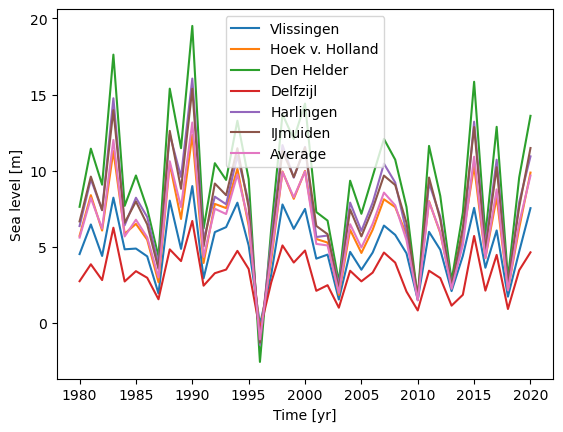

In [35]:
data_df[lst_u2].plot()
plt.ylabel('Sea level [m]')
plt.xlabel('Time [yr]')
plt.legend(labels = stations)

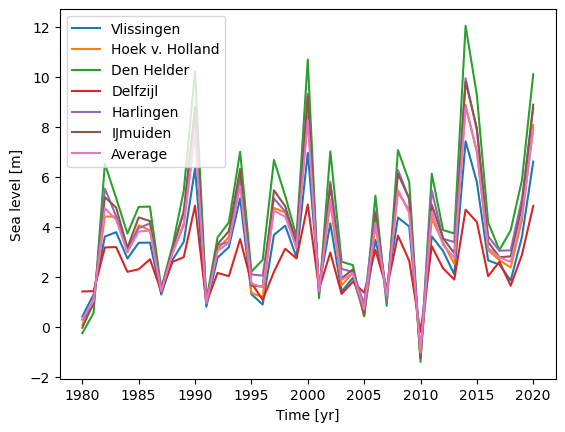

In [36]:
data_df[lst_v2].plot()
plt.ylabel('Sea level [m]')
plt.xlabel('Time [yr]')
plt.legend(labels = stations)

In [37]:
data_df[lst_u2]

,"(Vlissingen, $U \sqrt{u^2+v^2}$)","(Hoek v. Holland, $U \sqrt{u^2+v^2}$)","(Den Helder, $U \sqrt{u^2+v^2}$)","(Delfzijl, $U \sqrt{u^2+v^2}$)","(Harlingen, $U \sqrt{u^2+v^2}$)","(IJmuiden, $U \sqrt{u^2+v^2}$)","(Average, $U \sqrt{u^2+v^2}$)"
time,,,,,,,
1980,4.523649,5.724340,7.628645,2.743661,6.363389,6.670195,5.608980
1981,6.468433,8.392692,11.445472,3.853803,9.437038,9.611631,8.201511
1982,4.400341,6.068074,9.080299,2.817178,7.403647,7.412397,6.196989
1983,8.227916,11.288894,17.619799,6.255861,14.755543,13.974327,12.020390
1984,4.837162,5.858034,7.689235,2.725384,6.412833,6.577064,5.683285
1985,4.886095,6.506897,9.684964,3.402027,8.224622,7.975531,6.780023
1986,4.374397,5.465454,7.509739,2.967505,6.958736,6.469344,5.624197
1987,1.939227,2.672806,4.362568,1.556630,3.860798,3.552092,2.990687
1988,8.036016,10.438762,15.385594,4.833667,12.387395,12.614053,10.615914


#### Save DataFrame

In [38]:
path = '/Users/iriskeizer/Documents/Zeespiegelscenarios/data/era5/regression input'

data_df.to_csv(f'{path}/windstress_era5.csv')